# EDA dan Preprocessing: Dataset Kartu Pokémon Asli vs. Palsu

Notebook ini bertujuan untuk melakukan Analisis Data Eksplorasi (EDA) dan Preprocessing pada dataset gambar kartu Pokémon untuk memahami karakteristik yang membedakan kartu asli (real) dan palsu (fake) sebelum tahap modeling.

Link : https://www.kaggle.com/datasets/ongshujian/real-and-fake-pokemon-cards/data

## 1. Data Acquisition

### 1.1 Penjelasan Library yang Digunakan
- **os & glob**: Untuk berinteraksi dengan sistem file, yaitu membaca struktur folder dan menemukan path semua file gambar.
- **pandas**: Untuk membuat DataFrame yang berisi path file dan labelnya (real/fake).
- **matplotlib & seaborn**: Untuk visualisasi data.
- **PIL (Pillow)** & **cv2 (OpenCV)**: Pustaka untuk membuka dan memanipulasi file gambar.
- **tqdm**: Untuk menampilkan progress bar.
- **scikit-learn**: Untuk proses preprocessing seperti encoding dan pembagian data.

In [8]:
# Library untuk sistem file
import os
import glob

# Library untuk manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk memproses gambar
from PIL import Image
import cv2 

# Library untuk utility dan preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
print("Library siap digunakan!")

Library siap digunakan!


### 1.2 Memuat Path Gambar dan Label

In [9]:
train_img_path = 'data/train/'
train_labels_path = 'data/train_labels.csv'

# 1. Muat file CSV yang berisi label
labels_df = pd.read_csv(train_labels_path)

# 2. Ubah format kolom 'id' agar cocok dengan nama file
labels_df['id'] = labels_df['id'].astype(str)

# 3. Buat kolom 'filepath' yang berisi path lengkap ke setiap gambar
labels_df['filepath'] = labels_df['id'].apply(lambda x: os.path.join(train_img_path, x + '.jpg'))

# 4. Ganti label numerik (0, 1) menjadi teks ('real', 'fake')
label_map = {0: 'real', 1: 'fake'}
labels_df['label'] = labels_df['label'].map(label_map)

# 5. Buat DataFrame akhir yang akan kita gunakan untuk analisis
df = labels_df[['filepath', 'label']].copy()

# Acak urutan data dalam DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("DataFrame berhasil dibuat ulang dengan path yang benar.")
df.head()

DataFrame berhasil dibuat ulang dengan path yang benar.


filepath label
0  data/train/328.jpg  fake
1   data/train/34.jpg  real
2   data/train/16.jpg  real
3  data/train/315.jpg  fake
4   data/train/58.jpg  real

## 2. Data Profiling / Exploratory Data Analysis (EDA)

### 2.1 Analisis Distribusi Kelas (Asli vs. Palsu)

Jumlah gambar per label:
label
fake    250
real    123
Name: count, dtype: int64


C:\Users\asus\AppData\Local\Temp\ipykernel_9744\604340585.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


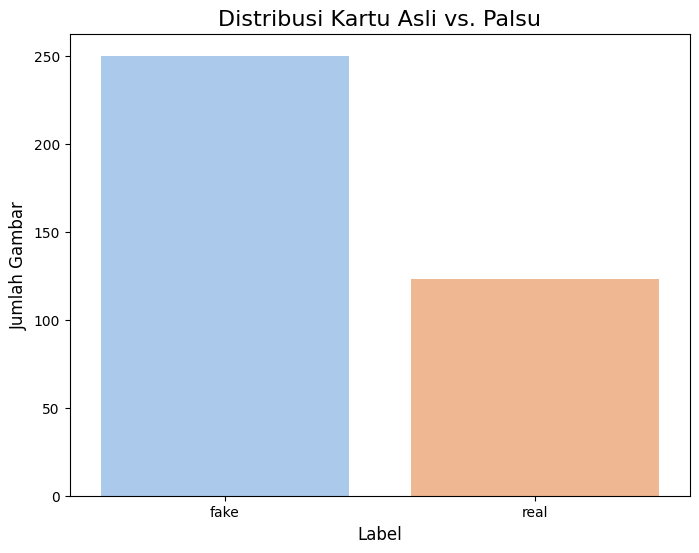

In [10]:
print("Jumlah gambar per label:")
print(df['label'].value_counts())

# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='pastel')
plt.title('Distribusi Kartu Asli vs. Palsu', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.show()

### 2.2 Visualisasi Contoh Gambar

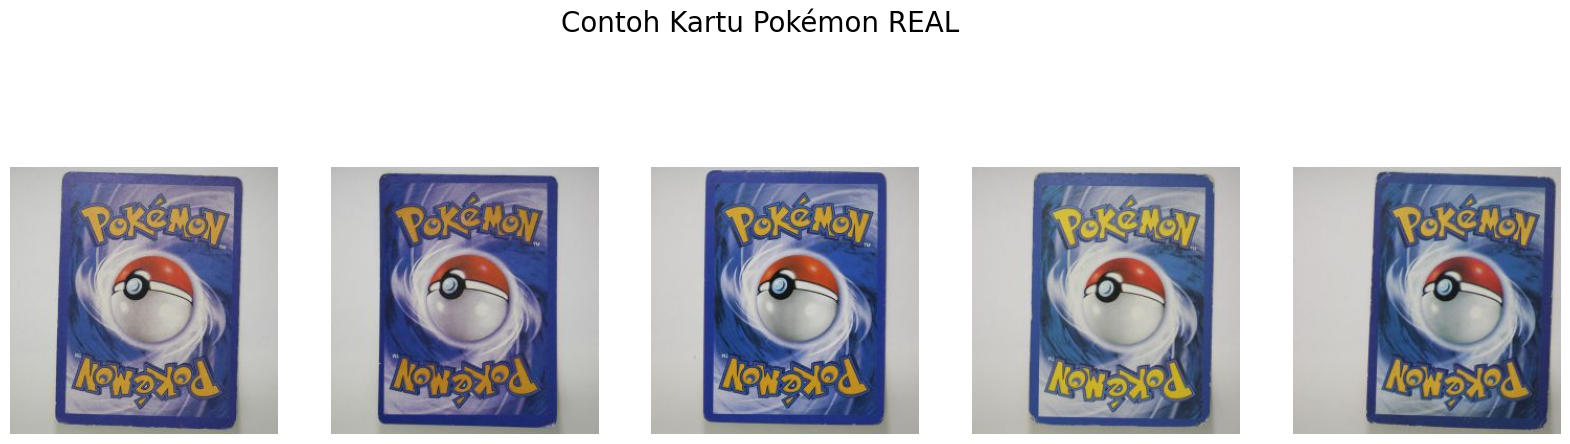

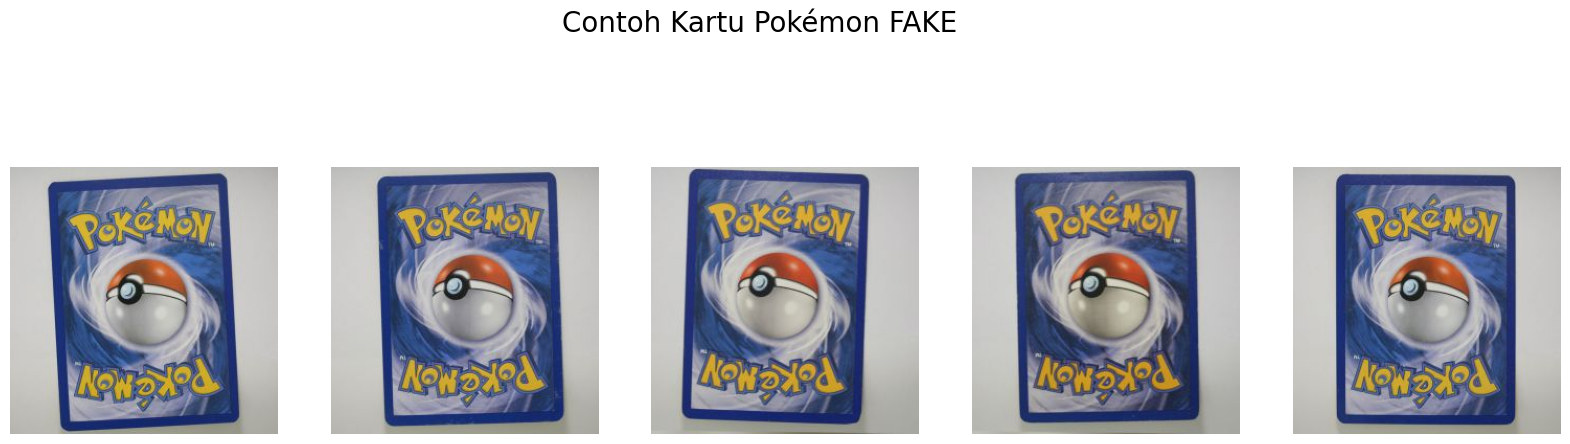

In [11]:
# Fungsi untuk menampilkan contoh gambar
def tampilkan_contoh_gambar(label_name, jumlah=5):
    plt.figure(figsize=(20, 6))
    
    contoh_files = df[df['label'] == label_name].sample(jumlah, random_state=1)['filepath'].values
    
    plt.suptitle(f'Contoh Kartu Pokémon {label_name.upper()}', fontsize=20)
    
    for i, file_path in enumerate(contoh_files):
        ax = plt.subplot(1, jumlah, i + 1)
        try:
            img = Image.open(file_path)
            plt.imshow(img)
        except FileNotFoundError:
            print(f"File tidak ditemukan di: {file_path}")
            ax.text(0.5, 0.5, 'File Not Found', ha='center', va='center')
        
        plt.axis('off')
    
    plt.show()

# Tampilkan contoh untuk kartu ASLI
tampilkan_contoh_gambar('real')

# Tampilkan contoh untuk kartu PALSU
tampilkan_contoh_gambar('fake')

### 2.3 Analisis Dimensi (Ukuran) Gambar

In [12]:
# Fungsi untuk mendapatkan dimensi (lebar, tinggi) dari sebuah gambar
def get_dimensi(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size # Mengembalikan tuple (lebar, tinggi)
    except:
        return (0, 0)

# Terapkan fungsi ke setiap baris dan buat kolom baru
df['dimensions'] = df['filepath'].apply(get_dimensi)

print("Ukuran Gambar yang Paling Umum:")
print(df['dimensions'].value_counts().head())

Ukuran Gambar yang Paling Umum:
dimensions
(256, 256)    373
Name: count, dtype: int64


## 3. Data Preparation / Preprocessing

Pada tahap ini, kita akan mempersiapkan data gambar agar siap untuk tahap modeling. Ada dua pendekatan yang akan kita siapkan sesuai materi *Feature Extraction*:

1.  **Pendekatan Modern**: Mempersiapkan piksel gambar mentah untuk diolah oleh model *Deep Learning* (CNN). Model CNN akan mengekstrak fiturnya secara otomatis.
2.  **Pendekatan Klasik**: Mengekstrak fitur secara manual (contoh: *Color Histogram*) untuk digunakan oleh model *Machine Learning* klasik (contoh: SVM, Logistic Regression).

### Pendekatan 1: Persiapan untuk Model Deep Learning (CNN) - (Disarankan)
Metode ini hanya melakukan resizing dan normalisasi. Fitur akan dipelajari secara otomatis oleh model CNN.

In [13]:
# Tentukan ukuran gambar yang seragam
IMG_SIZE = 128

# Siapkan list untuk menampung data gambar (X) dan labelnya (y) untuk pendekatan CNN
X_cnn = []
y_cnn = []

# Loop melalui setiap baris di DataFrame dengan progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing for CNN"):
    try:
        img = Image.open(row['filepath']).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        X_cnn.append(img_array)
        y_cnn.append(row['label'])
    except Exception as e:
        print(f"Error: {e}")

# Ubah list menjadi numpy array
X_cnn = np.array(X_cnn)
y_cnn = np.array(y_cnn)

print(f"\nPreprocessing untuk CNN selesai. Bentuk data (X_cnn): {X_cnn.shape}")

Processing for CNN: 100%|██████████| 373/373 [00:05<00:00, 73.38it/s] 



Preprocessing untuk CNN selesai. Bentuk data (X_cnn): (373, 128, 128, 3)


### Pendekatan 2: Feature Extraction Klasik (Color Histogram)
Metode ini mengekstrak fitur distribusi warna dari setiap gambar. Fitur ini nantinya bisa digunakan untuk model klasifikasi seperti Logistic Regression atau SVM.

In [14]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        return hist.flatten()
    except Exception as e:
        return None

print("Memulai ekstraksi fitur Color Histogram (mungkin butuh beberapa saat)...")
tqdm.pandas(desc="Extracting Histograms")
X_hist_features = df['filepath'].progress_apply(extract_color_histogram)
print("Ekstraksi fitur Color Histogram selesai.")

# Hapus baris yang mungkin gagal diproses
valid_indices = X_hist_features.notna()
X_hist = np.array(X_hist_features[valid_indices].tolist())
y_hist = df[valid_indices]['label'].values

print(f"Bentuk data fitur histogram (X_hist): {X_hist.shape}")

Memulai ekstraksi fitur Color Histogram (mungkin butuh beberapa saat)...


Extracting Histograms: 100%|██████████| 373/373 [00:02<00:00, 128.85it/s]

Ekstraksi fitur Color Histogram selesai.
Bentuk data fitur histogram (X_hist): (373, 512)


## 4. Label Encoding dan Train-Test Split

Tahap terakhir persiapan data adalah mengubah label menjadi numerik dan membagi kedua set data (CNN & Histogram) menjadi data latih dan data uji.

In [15]:
# Label Encoding (mengubah 'real'/'fake' menjadi 0/1)
# Proses ini sama untuk kedua pendekatan
le = LabelEncoder()
y_encoded_cnn = le.fit_transform(y_cnn)
y_encoded_hist = le.fit_transform(y_hist) # y_hist sudah 1D, jadi langsung

print("Mapping Label:")
for i, label in enumerate(le.classes_):
    print(f"{label} -> {i}")

# Membagi data hasil Pendekatan 1 (CNN)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_encoded_cnn, test_size=0.2, random_state=42, stratify=y_encoded_cnn)

# Membagi data hasil Pendekatan 2 (Histogram)
X_train_hist, X_test_hist, y_train_hist, y_test_hist = train_test_split(X_hist, y_encoded_hist, test_size=0.2, random_state=42, stratify=y_encoded_hist)

print("\nData siap untuk modeling dengan dua pendekatan:")
print(f"  - Bentuk X_train untuk CNN: {X_train_cnn.shape}")
print(f"  - Bentuk X_train untuk Color Histogram: {X_train_hist.shape}")

Mapping Label:
fake -> 0
real -> 1

Data siap untuk modeling dengan dua pendekatan:
  - Bentuk X_train untuk CNN: (298, 128, 128, 3)
  - Bentuk X_train untuk Color Histogram: (298, 512)


## 5. Kesimpulan & Langkah Selanjutnya

**Langkah Selanjutnya:**
Anda sekarang bisa memilih salah satu set data di atas untuk melanjutkan ke tahap **Modeling**.
- Gunakan data CNN (`X_train_cnn`, `y_train_cnn`) untuk melatih model seperti **Convolutional Neural Network**.
- Gunakan data Color Histogram (`X_train_hist`, `y_train_hist`) untuk melatih model seperti **Logistic Regression**, **SVM**, atau **Random Forest**.